In [147]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
from pymorphy2 import MorphAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sklearn.metrics 

import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

from sklearn.cluster import KMeans

#pip install googletrans==3.1.0a0 что бы заработал !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import googletrans
from googletrans import Translator

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip thi
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sorok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sorok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sorok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sorok\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [102]:
train_issues = pd.read_csv('train_issues.csv')
train_comments = pd.read_csv('train_comments.csv')
test_issues = pd.read_csv('test_issues.csv')
test_comments = pd.read_csv('test_comments.csv')
employees = pd.read_csv('employees.csv')
sample_solution = pd.read_csv('sample_solution.csv')

In [148]:
train_issues = pd.read_csv('train_issues_lang.csv')
train_comments_lang = pd.read_csv('train_comments_lang.csv')

test_issues = pd.read_csv('test_issues_lang.csv')
test_comments_lang = pd.read_csv('test_comments_lang.csv')

# откинем выбросы
train_issues = train_issues[(train_issues['overall_worklogs']<100000)&(train_issues['overall_worklogs']>800)]

In [149]:
# функция получения биграммы, триграммы и 4граммы, на вход сырые предложения
# параметры min_count=1, threshold=10, threshold=10
def bi_tri_grammer(data):
    data = data.values.tolist()
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    data_words = list(sent_to_words(data))
    # Convert to list
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    data_words = list(sent_to_words(data_words))
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=1, threshold=5) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=5)
    fourgram =  gensim.models.Phrases(trigram[bigram[data_words]], threshold=10)
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    fourgram_mod = gensim.models.phrases.Phraser(fourgram)
    # See trigram example
    return list(bigram_mod[data_words]), list(trigram_mod[bigram_mod[data_words]]), list(fourgram_mod[trigram_mod[bigram_mod[data_words]]])

# если на вход подаем список списков [['aabb'], ['cc', 'dd']], то делаем такую предобработку 
# data = [' '.join(x) for x in list_of_list ]

In [150]:
# делаем 2-3-4граммы 

train_issues['summary'] = [' '.join(x) for x in bi_tri_grammer(train_issues['summary'])[0]]
test_issues['summary'] = [' '.join(x) for x in bi_tri_grammer(test_issues['summary'])[0]]
#train_comments_lang['text'] = [' '.join(x) for x in bi_tri_grammer(train_comments['text'])[2]]
#test_comments_lang['text'] = [' '.join(x) for x in bi_tri_grammer(test_comments['text'])[2]]

In [151]:
def only_ngramms(doc):
    doc = [x for x in doc.split() if '_' in x]
    return doc

train_issues['summary'] = train_issues['summary'].apply(only_ngramms)
train_issues['summary'].value_counts()


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                            2520
[unit_tests]                                    32
[need_to]                                       28
[test_layout]                                   28
[planing_tasks]                                 27
                                              ... 
[draft_status, dont_have, assign_lesson]         1
[markup_for, according_to, updated_design]       1
[handle_uk, lesson_creation]                     1
[onboarding_forms]                               1
[dataset_from, teacherly_slack]                  1
Name: summary, Length: 4443, dtype: int64

In [155]:
train_issues

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,lang_summary
0,819952,2019-10-01 05:57:18.000,SM-10678,[ui_тесты],5,93,93,1800,ru
1,819949,2019-10-01 05:59:45.000,SM-10679,[ui_тесты],5,93,93,7200,ru
2,819947,2019-10-01 06:00:38.000,SM-10680,[ui_тесты],5,93,93,14400,ru
3,819943,2019-10-01 06:02:49.000,SM-10682,[ui_тесты],5,93,93,900,ru
4,819941,2019-10-01 06:03:26.000,SM-10683,[ui_тесты],5,93,93,900,ru
...,...,...,...,...,...,...,...,...,...
9081,688414,2020-06-15 09:47:30.000,ADBK-779,[teachers_pages],48,1,116,26040,en
9082,670934,2020-06-02 10:08:14.000,LJ-1,"[set_up, neo_by, dataset_from]",56,2,2,16200,en
9083,670932,2020-06-05 09:52:12.000,LJ-3,"[set_up, neo_by]",56,2,2,3600,en
9084,670931,2020-06-05 13:46:38.000,LJ-4,"[dataset_from, teacherly_slack]",56,2,2,6300,en


In [157]:
# рабочая функция лематизации и приведения текстов EN RU

morph = MorphAnalyzer()

def lemmatize(doc, min_len_word=4, max_len_word = 10000, len_phrase = 2): # 2,15,10
    patterns = "0-9[!#$%&'()*+,./:;<=>?@[\]^`{|}~—\"\-]+"
    stop_words = stopwords.words('english') + stopwords.words('russian') + list(patterns)
    lemmatizer = WordNetLemmatizer()
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    tokens = []
    doc = re.sub(patterns, ' ', doc)
    for token in doc.split():
        if token not in stop_words: #and token 
            token = token.strip()
            token = morph.normal_forms(token)[0]
            token = lemmatizer.lemmatize(token)
            if len(token) >=min_len_word and len(token)<=max_len_word: # условие длинны слова !!!
                tokens.append(token)
    if len(tokens) >= len_phrase: # условие длинны выражения !!!
        return tokens #str(' '.join(tokens[0:how_many_tokens]))

In [108]:
def transform(train_issues, train_comments, employees, comments_lang):
    # Убрали столбец с временем создани задачи
    # Добавили столбец с количеством коментов
    train = train_issues.drop(columns=['created', 'key'], axis=1)
    train['lematize_summary'] = train_issues['summary'].apply(lemmatize).fillna('NotDefined')
    train = pd.merge(train, train_comments.groupby(by='issue_id').count()['text'], left_on="id", right_on="issue_id", how='left').fillna(0)
    train.rename(columns={'text':'comments'}, inplace=True)
    #employees_data = employees.drop(columns=['active', 'full_name', 'salary_calculation_type', 'english_level']).fillna('NotDefined')
    #mployees_data = employees_data.drop(columns=['is_nda_signed', 'is_labor_contract_signed', 'is_added_one_to_one'], inplace=True)
    # добавим столбец с суммой комментариев
    #train = pd.merge(train, train_comments.groupby('issue_id')['text'].apply(lambda x: ' '.join(x)), left_on="id", right_on="issue_id", how='left').fillna('NotDefined')
    #train['lematize_comments'] = train['text'].apply(lemmatize).fillna('NotDefined')
    #train.drop(columns='text', inplace=True)
    # добавили в train данные исполнителя, заказчика оставили просто как id
    #train = pd.merge(train, employees_data.iloc[:,0:], left_on="assignee_id", right_on="id", how='left')
    # обавим признак языка коммента
    #train = pd.merge(train, comments_lang, left_on="id_x", right_on="issue_id", how='left').fillna('NotDefined')
    # удалим лишние столбцы В ТОМ ЧИСЛЕ SUMMARY пока нет NLP модели
    #train.drop(columns=['id_y', 'id_x',  'summary', 'issue_id', 'text'], inplace=True)
    return(train)

In [116]:
train_transform = transform(train_issues, train_comments, employees, train_comments)
test_transform = transform(test_issues, test_comments, employees, test_comments)

AttributeError: 'list' object has no attribute 'translate'

In [158]:
train_transform = train_issues

In [63]:
from itertools import chain
doc  = [i for i in train_transform['lematize_summary']]
list(chain(*doc))
ddd = pd.DataFrame(columns=['words'])
ddd['words'] = list(chain(*doc))
ddd['cnt'] = 0
ddd.groupby(by = 'words').count().sort_values(by=['cnt'], ascending=False).reset_index()
word_list = ddd.groupby(by = 'words').count().sort_values(by=['cnt'], ascending=False).reset_index()['words']
word_list = [x for x in word_list if len(x)>1]
word_list = word_list[0:6000] # имеет значение !!!!!!!!!!!!!!!!!!!!!!!!!!!1

In [64]:
def word_filter(doc):
    x = [x for x in doc if x in word_list]
    return(x)
train_transform['lematize_summary'] = train_transform['lematize_summary'].apply(word_filter)

In [65]:
# проверка на удаление лишнего
from itertools import chain
doc  = [i for i in train_transform['lematize_summary']]
list(chain(*doc))
ddd = pd.DataFrame(columns=['words'])
ddd['words'] = list(chain(*doc))
ddd['cnt'] = 0
ddd.groupby(by = 'words').count().sort_values(by=['cnt'], ascending=False).reset_index()

,words,cnt
0,create,404
1,page,375
2,lesson,354
3,markup,320
4,test,318
...,...,...
5995,studentinvites,1
5996,studentroom,1
5997,studentspending,1
5998,studybug,1


In [159]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features


In [160]:
train_transform

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,lang_summary
0,819952,2019-10-01 05:57:18.000,SM-10678,[ui_тесты],5,93,93,1800,ru
1,819949,2019-10-01 05:59:45.000,SM-10679,[ui_тесты],5,93,93,7200,ru
2,819947,2019-10-01 06:00:38.000,SM-10680,[ui_тесты],5,93,93,14400,ru
3,819943,2019-10-01 06:02:49.000,SM-10682,[ui_тесты],5,93,93,900,ru
4,819941,2019-10-01 06:03:26.000,SM-10683,[ui_тесты],5,93,93,900,ru
...,...,...,...,...,...,...,...,...,...
9081,688414,2020-06-15 09:47:30.000,ADBK-779,[teachers_pages],48,1,116,26040,en
9082,670934,2020-06-02 10:08:14.000,LJ-1,"[set_up, neo_by, dataset_from]",56,2,2,16200,en
9083,670932,2020-06-05 09:52:12.000,LJ-3,"[set_up, neo_by]",56,2,2,3600,en
9084,670931,2020-06-05 13:46:38.000,LJ-4,"[dataset_from, teacherly_slack]",56,2,2,6300,en


In [130]:
model_summary = Word2Vec(sentences=train_transform['summary'], vector_size=100, workers=1, seed=SEED, min_count=1)
vectorized_summary = vectorize(train_transform['summary'], model=model_summary)

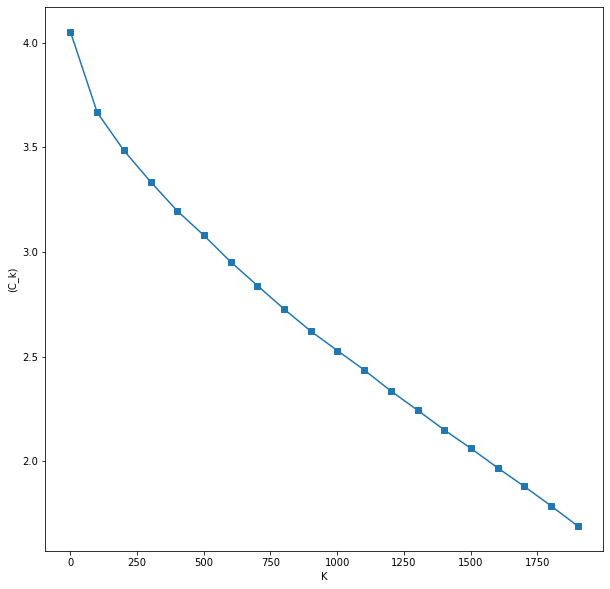

In [131]:
# for summary
from sklearn.cluster import KMeans
inertia = []
for k in range(1,2000,100):
    mbk  = KMeans(n_clusters=k,init='random', random_state=1).fit(vectorized_summary)
    inertia.append(np.sqrt(mbk.inertia_))
plt.figure(figsize=(10, 10))
plt.plot(range(1,2000,100),inertia,marker='s')
plt.xlabel('K')
plt.ylabel('(C_k)')
plt.show()

In [121]:
mbk  = KMeans(n_clusters=5,init='random').fit(vectorized_summary)
y_kmeansMBK = mbk.predict(vectorized_summary)
Num = [] 
Num = [pt for pt in y_kmeansMBK]
df = {"Num_Cluster": Num}
dfMBK = pd.DataFrame(df)
train_transform['cluster_summary'] = dfMBK.iloc[0:train_transform.shape[0],0]
test_transform['cluster_summary'] = dfMBK.iloc[train_transform.shape[0]:,0].reset_index(drop=True)

In [161]:
###########################################################################
def str_(doc):
    doc = ' '.join(doc)
    return doc
train_transform['summary'] = train_transform['summary'].apply(str_)

In [162]:
train_transform

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,lang_summary
0,819952,2019-10-01 05:57:18.000,SM-10678,ui_тесты,5,93,93,1800,ru
1,819949,2019-10-01 05:59:45.000,SM-10679,ui_тесты,5,93,93,7200,ru
2,819947,2019-10-01 06:00:38.000,SM-10680,ui_тесты,5,93,93,14400,ru
3,819943,2019-10-01 06:02:49.000,SM-10682,ui_тесты,5,93,93,900,ru
4,819941,2019-10-01 06:03:26.000,SM-10683,ui_тесты,5,93,93,900,ru
...,...,...,...,...,...,...,...,...,...
9081,688414,2020-06-15 09:47:30.000,ADBK-779,teachers_pages,48,1,116,26040,en
9082,670934,2020-06-02 10:08:14.000,LJ-1,set_up neo_by dataset_from,56,2,2,16200,en
9083,670932,2020-06-05 09:52:12.000,LJ-3,set_up neo_by,56,2,2,3600,en
9084,670931,2020-06-05 13:46:38.000,LJ-4,dataset_from teacherly_slack,56,2,2,6300,en


In [163]:
X = train_transform[['project_id','assignee_id','creator_id','lang_summary','summary']].fillna('UD')
y = train_transform['overall_worklogs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [164]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(iterations=1000)
cat.fit(X,y,verbose=False, plot=True, cat_features=['project_id','assignee_id','creator_id','lang_summary','summary'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [165]:
expected_y  = y_test
predicted_y = cat.predict(X_test)
predicted_y = [600 if x<600 else x for x in predicted_y]
predicted_y = list(map(lambda x: x-x % -100, predicted_y))
print(r2_score(expected_y, predicted_y ))

0.21274824598153008


In [166]:
expected_y  = y
predicted_y = cat.predict(X)
predicted_y = [600 if x<600 else x for x in predicted_y]
predicted_y = list(map(lambda x: x-x % -100, predicted_y))
print(r2_score(expected_y, predicted_y ))

0.20895225633110226


In [168]:
predicted_y = cat.predict(test_transform[['project_id','assignee_id','creator_id','lang_summary','summary']])
predicted_y = [600 if x<600 else x for x in predicted_y]
predicted_y = list(map(lambda x: x-x % -100, predicted_y))

sample_solution = pd.read_csv('sample_solution.csv')
sample_solution['overall_worklogs'] = predicted_y
sample_solution.to_csv('sample_solution_3.csv', index=False)
# дает результат в лидерборде 